# Import libraries

In [273]:
import os
import random
import gc

import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.cluster import KMeans

import cv2
from imutils import paths
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [274]:
os.sys.path.append('../src')
from helpers import resize_to_fit

# Load dataset

In [275]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

In [276]:
CAPTCHA_IMAGES_FOLDER = "../data/samples"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(CAPTCHA_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Grab the labels
    label = image_file.split(os.path.sep)[-1].split('.')[-2]

    # Add the image and it's label to our training data
    data.append(image)
    labels.append(label)

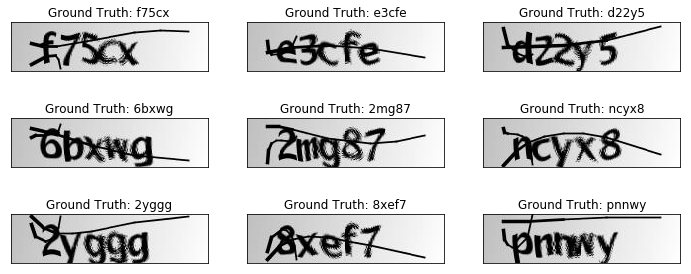

In [277]:
# show sample images
fig = plt.figure(figsize=(12, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(data[i], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

# Pre-processing

## Otsu threshold

In [278]:
data_pre = []
for e in data:
    ret, th = cv2.threshold(e, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(th, kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=1)

    data_pre.append(erosion)

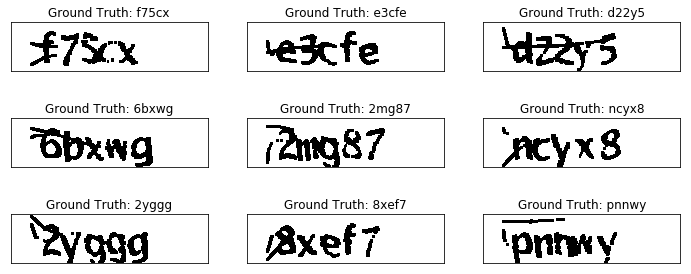

In [279]:
# show sample images
fig = plt.figure(figsize=(12, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(data_pre[i], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

# K-Means

In [280]:
#data_pre = data_pre[:100]

In [281]:
data_pts = []
for e in data_pre:
    data_pts.append(np.where(e == 0))
data_pts = np.array(data_pts)
data_pts.shape

(1070, 2)

In [282]:
X = []
thres = 7
for e in data_pts:
    x = (np.vstack((e[1],np.flip(e[0])))).T
    l = []
    # Discard columns with less than thres points
    for i in range(200):
        if len(x[x[:,0] == i]) > thres:
            for f in x[x[:,0] == i]:
                l.append(f)
    x = np.array(l)
    X.append(x)
X = np.array(X)
X.shape

(1070,)

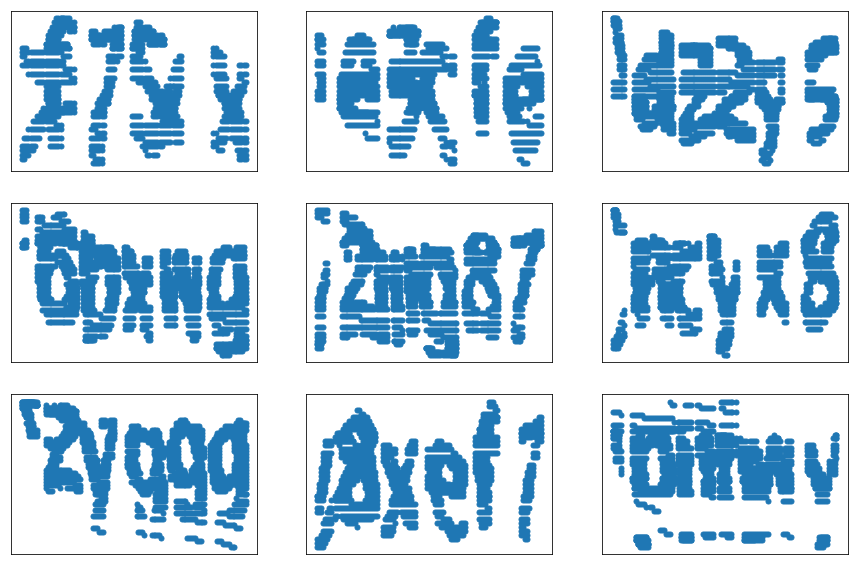

In [283]:
# Show points
fig = plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(X[i][:,0], X[i][:,1], s=100, marker='.')
    plt.xticks([])
    plt.yticks([])

In [284]:
# Find clusters
y_kmeans = []
centers_kmeans = []
for i, x in enumerate(X):
    kmeans = KMeans(n_clusters=5)#, init=np.array([(i*200/6.0, 25) for i in range(1,6)]))
    kmeans.fit(x)
    centers_kmeans.append(kmeans.cluster_centers_)
    y_kmeans.append(kmeans.predict(x))

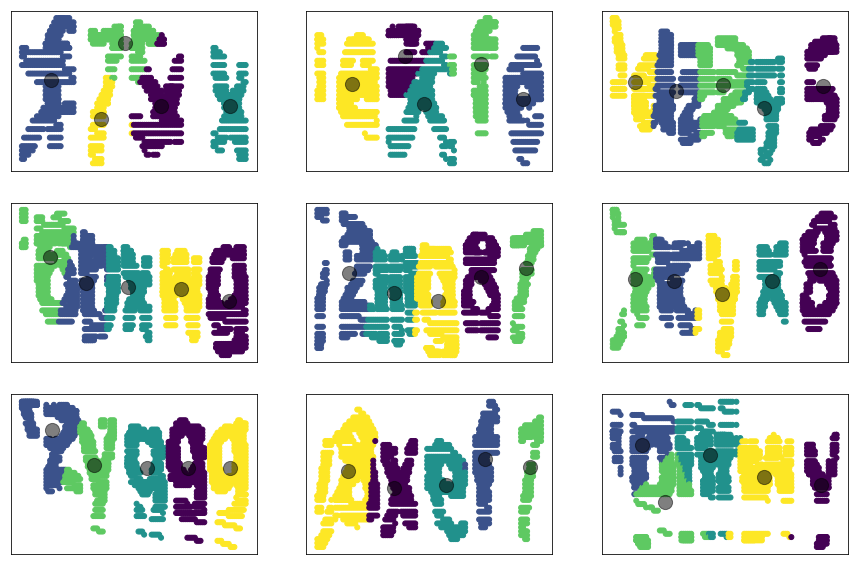

In [285]:
# Show clusters
fig = plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(X[i][:, 0], X[i][:, 1], c=y_kmeans[i], s=100, cmap='viridis', marker='.')
    centers = centers_kmeans[i]
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.xticks([])
    plt.yticks([])

In [286]:
# Projection in x-axis
X_proj = [x[:,0].reshape(-1,1) for x in X]

In [287]:
# Find clusters in projected data
y_kmeans_proj = []
centers_kmeans_proj = []
for i, x in enumerate(X_proj):
    kmeans = KMeans(n_clusters=5)#, init=np.array([(i*200/6.0, 25) for i in range(1,6)]))
    kmeans.fit(x)
    centers_kmeans_proj.append(kmeans.cluster_centers_)
    y_kmeans_proj.append(kmeans.predict(x))

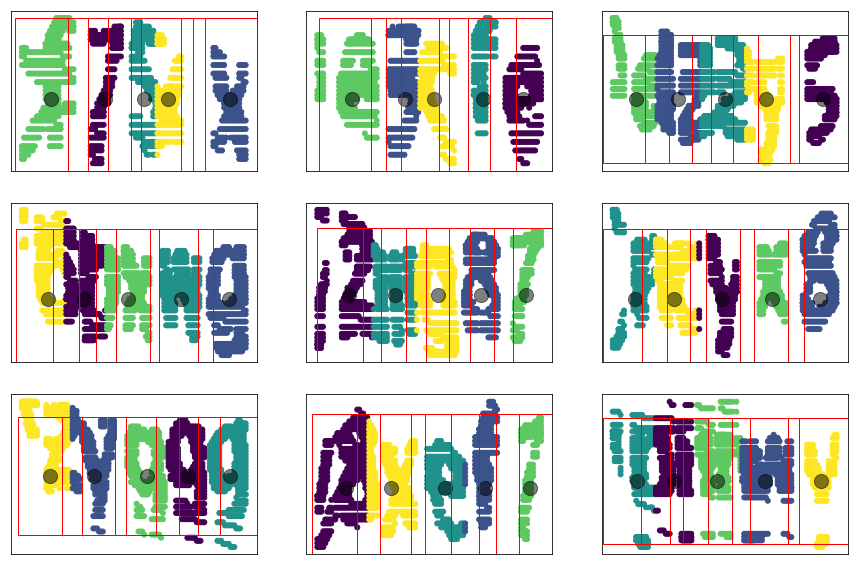

In [288]:
# Show clusters
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(X[i][:, 0], X[i][:, 1], c=y_kmeans_proj[i], s=100, cmap='viridis', marker='.')
    centers = centers_kmeans_proj[i]
    plt.scatter(centers, np.ones(centers.shape)*25, c='black', s=200, alpha=0.5, marker='o')
    plt.xticks([])
    plt.yticks([])
    currentAxis = plt.gca()
    for c in centers:
        currentAxis.add_patch(Rectangle((c - 17, 25 - 19), 34, 38, color="red", fill=False))
plt.show()

# Crop and save images

In [289]:
centers = np.sort(centers, axis=0)

In [290]:
data_chars = []
for i, e in enumerate(data):
    chars = []
    for i in range(5):
        chars.append(e[:,int(centers[i][0]-15):int(centers[i][0]+15)])
    data_chars.append(chars)

In [291]:
letters_dir = os.path.join(data_dir, 'letters/')
letters_dir = '../data/letters'

In [292]:
for i,e in enumerate(data_chars):
    for j in range(5):
        if not(os.path.isdir(''.join((letters_dir,'/',labels[i][j],'/')))):
            os.mkdir(''.join((letters_dir,'/',labels[i][j],'/')))
        cv2.imwrite(''.join((letters_dir,'/',labels[i][j],'/',str(i),'.png')),e[j])

## Convolutional Neural Network

In [293]:
LETTER_IMAGES_FOLDER = letters_dir

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 28, 28)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


In [294]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [295]:
# Split the training data into separate train and test sets
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [296]:
batch_size_train = X_train.shape[0]/1000
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 5
log_interval = 10

In [297]:
X_train_t = (torch.from_numpy(X_train).float().transpose(1,3)).transpose(2,3)
y_train_t = torch.from_numpy(y_train).long()

train_data = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=round(batch_size_train), shuffle=True)

In [298]:
X_test_t = (torch.from_numpy(X_test).float().transpose(1,3)).transpose(2,3)
y_test_t = torch.from_numpy(y_test).long()

test_data = torch.utils.data.TensorDataset(X_test_t, y_test_t)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [299]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

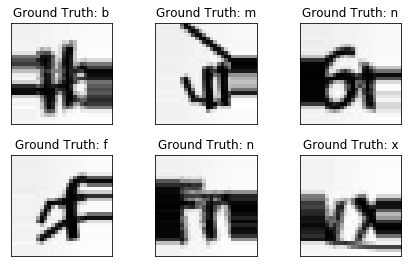

In [300]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(le.inverse_transform(example_targets)[i]))
    plt.xticks([])
    plt.yticks([])

In [301]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 32)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)

In [302]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [303]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [304]:
def train(epoch, v=True):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if v:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')

In [305]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [306]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 6.6396, Accuracy: 35/1199 (2%)

Train Epoch: 1 [0/3597 (0%)]	Loss: 1.404106
Train Epoch: 1 [40/3597 (1%)]	Loss: 1.360918
Train Epoch: 1 [80/3597 (2%)]	Loss: 1.378897
Train Epoch: 1 [120/3597 (3%)]	Loss: 1.382966
Train Epoch: 1 [160/3597 (4%)]	Loss: 1.403318
Train Epoch: 1 [200/3597 (6%)]	Loss: 1.431519
Train Epoch: 1 [240/3597 (7%)]	Loss: 1.380142
Train Epoch: 1 [280/3597 (8%)]	Loss: 1.367349
Train Epoch: 1 [320/3597 (9%)]	Loss: 1.318176
Train Epoch: 1 [360/3597 (10%)]	Loss: 1.491905
Train Epoch: 1 [400/3597 (11%)]	Loss: 1.368980
Train Epoch: 1 [440/3597 (12%)]	Loss: 1.359307
Train Epoch: 1 [480/3597 (13%)]	Loss: 1.369786
Train Epoch: 1 [520/3597 (14%)]	Loss: 1.377184
Train Epoch: 1 [560/3597 (16%)]	Loss: 1.386402
Train Epoch: 1 [600/3597 (17%)]	Loss: 1.376233
Train Epoch: 1 [640/3597 (18%)]	Loss: 1.393073
Train Epoch: 1 [680/3597 (19%)]	Loss: 1.390743
Train Epoch: 1 [720/3597 (20%)]	Loss: 1.379355
Train Epoch: 1 [760/3597 (21%)]	Loss: 1.389312
Train Epoch: 1 [800

Train Epoch: 2 [3240/3597 (90%)]	Loss: 1.386294
Train Epoch: 2 [3280/3597 (91%)]	Loss: 1.386294
Train Epoch: 2 [3320/3597 (92%)]	Loss: 1.386294
Train Epoch: 2 [3360/3597 (93%)]	Loss: 1.386294
Train Epoch: 2 [3400/3597 (94%)]	Loss: 1.386294
Train Epoch: 2 [3440/3597 (96%)]	Loss: 1.386294
Train Epoch: 2 [3480/3597 (97%)]	Loss: 1.386294
Train Epoch: 2 [3520/3597 (98%)]	Loss: 1.386294
Train Epoch: 2 [3560/3597 (99%)]	Loss: 1.386294

Test set: Avg. loss: 6.6398, Accuracy: 0/1199 (0%)

Train Epoch: 3 [0/3597 (0%)]	Loss: 1.386294
Train Epoch: 3 [40/3597 (1%)]	Loss: 1.386294
Train Epoch: 3 [80/3597 (2%)]	Loss: 1.386294
Train Epoch: 3 [120/3597 (3%)]	Loss: 1.386294
Train Epoch: 3 [160/3597 (4%)]	Loss: 1.386294
Train Epoch: 3 [200/3597 (6%)]	Loss: 1.386294
Train Epoch: 3 [240/3597 (7%)]	Loss: 1.386294
Train Epoch: 3 [280/3597 (8%)]	Loss: 1.386294
Train Epoch: 3 [320/3597 (9%)]	Loss: 1.386294
Train Epoch: 3 [360/3597 (10%)]	Loss: 1.386294
Train Epoch: 3 [400/3597 (11%)]	Loss: 1.386294
Train Epoch

Train Epoch: 4 [2880/3597 (80%)]	Loss: 1.386294
Train Epoch: 4 [2920/3597 (81%)]	Loss: 1.386294
Train Epoch: 4 [2960/3597 (82%)]	Loss: 1.386294
Train Epoch: 4 [3000/3597 (83%)]	Loss: 1.386294
Train Epoch: 4 [3040/3597 (84%)]	Loss: 1.386294
Train Epoch: 4 [3080/3597 (86%)]	Loss: 1.386294
Train Epoch: 4 [3120/3597 (87%)]	Loss: 1.386294
Train Epoch: 4 [3160/3597 (88%)]	Loss: 1.386294
Train Epoch: 4 [3200/3597 (89%)]	Loss: 1.386294
Train Epoch: 4 [3240/3597 (90%)]	Loss: 1.386294
Train Epoch: 4 [3280/3597 (91%)]	Loss: 1.386294
Train Epoch: 4 [3320/3597 (92%)]	Loss: 1.386294
Train Epoch: 4 [3360/3597 (93%)]	Loss: 1.386294
Train Epoch: 4 [3400/3597 (94%)]	Loss: 1.386294
Train Epoch: 4 [3440/3597 (96%)]	Loss: 1.386294
Train Epoch: 4 [3480/3597 (97%)]	Loss: 1.386294
Train Epoch: 4 [3520/3597 (98%)]	Loss: 1.386294
Train Epoch: 4 [3560/3597 (99%)]	Loss: 1.386294

Test set: Avg. loss: 6.6398, Accuracy: 0/1199 (0%)

Train Epoch: 5 [0/3597 (0%)]	Loss: 1.386294
Train Epoch: 5 [40/3597 (1%)]	Loss: 1.3

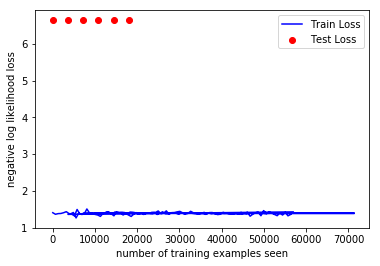

In [307]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [28]:
with torch.no_grad():
    output = net(example_data)

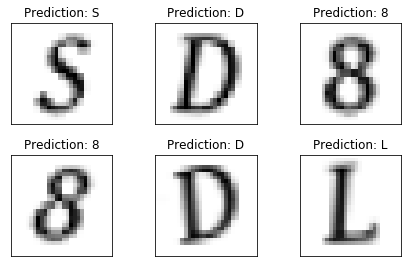

In [29]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(le.inverse_transform(output.data.max(1, keepdim=True)[1][i])[0]))
    plt.xticks([])
    plt.yticks([])

In [30]:
class Net(nn.Module):
    def __init__(self, H, D):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 32)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)


Net with H = 50, D = 0

Test set: Avg. loss: 6.8778, Accuracy: 652/9686 (6%)


Test set: Avg. loss: 3.5354, Accuracy: 9593/9686 (99%)


Test set: Avg. loss: 3.5106, Accuracy: 9607/9686 (99%)


Test set: Avg. loss: 3.5020, Accuracy: 9615/9686 (99%)


Test set: Avg. loss: 3.5360, Accuracy: 9580/9686 (98%)


Test set: Avg. loss: 3.5208, Accuracy: 9590/9686 (99%)



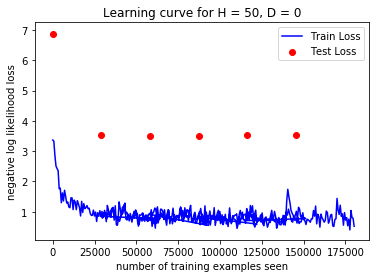


Net with H = 50, D = 0.3

Test set: Avg. loss: 6.8816, Accuracy: 276/9686 (2%)


Test set: Avg. loss: 3.5532, Accuracy: 9570/9686 (98%)


Test set: Avg. loss: 3.5179, Accuracy: 9593/9686 (99%)


Test set: Avg. loss: 3.5331, Accuracy: 9590/9686 (99%)


Test set: Avg. loss: 3.6100, Accuracy: 9486/9686 (97%)


Test set: Avg. loss: 3.5243, Accuracy: 9596/9686 (99%)



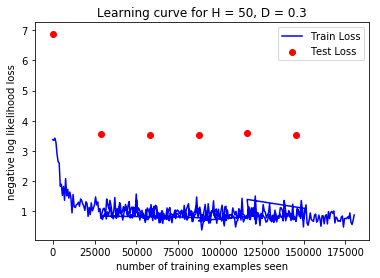


Net with H = 50, D = 0.5

Test set: Avg. loss: 6.8839, Accuracy: 62/9686 (0%)


Test set: Avg. loss: 3.5335, Accuracy: 9602/9686 (99%)


Test set: Avg. loss: 3.6005, Accuracy: 9575/9686 (98%)


Test set: Avg. loss: 3.5053, Accuracy: 9615/9686 (99%)


Test set: Avg. loss: 3.5976, Accuracy: 9600/9686 (99%)


Test set: Avg. loss: 3.4972, Accuracy: 9628/9686 (99%)



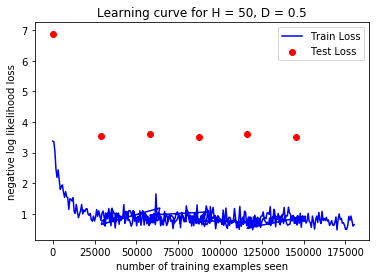


Net with H = 50, D = 0.7

Test set: Avg. loss: 6.8815, Accuracy: 165/9686 (1%)


Test set: Avg. loss: 3.6143, Accuracy: 9494/9686 (98%)


Test set: Avg. loss: 3.6591, Accuracy: 9434/9686 (97%)


Test set: Avg. loss: 3.5830, Accuracy: 9517/9686 (98%)


Test set: Avg. loss: 3.5624, Accuracy: 9503/9686 (98%)


Test set: Avg. loss: 3.5919, Accuracy: 9527/9686 (98%)



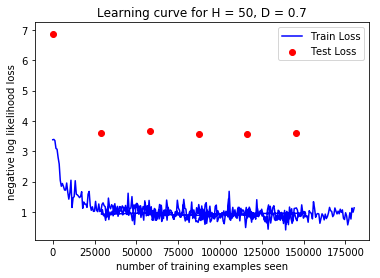


Net with H = 120, D = 0

Test set: Avg. loss: 6.8798, Accuracy: 783/9686 (8%)


Test set: Avg. loss: 3.5386, Accuracy: 9617/9686 (99%)


Test set: Avg. loss: 3.5126, Accuracy: 9615/9686 (99%)


Test set: Avg. loss: 3.5104, Accuracy: 9629/9686 (99%)


Test set: Avg. loss: 3.4970, Accuracy: 9627/9686 (99%)


Test set: Avg. loss: 3.5691, Accuracy: 9612/9686 (99%)



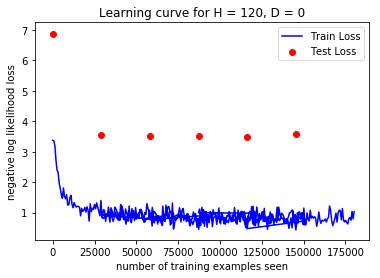


Net with H = 120, D = 0.3

Test set: Avg. loss: 6.8766, Accuracy: 657/9686 (6%)


Test set: Avg. loss: 3.5267, Accuracy: 9604/9686 (99%)


Test set: Avg. loss: 3.4847, Accuracy: 9628/9686 (99%)


Test set: Avg. loss: 3.4963, Accuracy: 9635/9686 (99%)


Test set: Avg. loss: 3.4872, Accuracy: 9630/9686 (99%)


Test set: Avg. loss: 3.4887, Accuracy: 9617/9686 (99%)



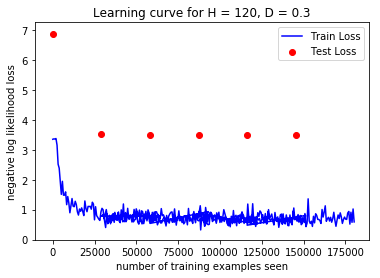


Net with H = 120, D = 0.5

Test set: Avg. loss: 6.8796, Accuracy: 516/9686 (5%)


Test set: Avg. loss: 3.6079, Accuracy: 9496/9686 (98%)


Test set: Avg. loss: 3.5350, Accuracy: 9568/9686 (98%)


Test set: Avg. loss: 3.5184, Accuracy: 9597/9686 (99%)


Test set: Avg. loss: 3.5998, Accuracy: 9566/9686 (98%)


Test set: Avg. loss: 3.5490, Accuracy: 9561/9686 (98%)



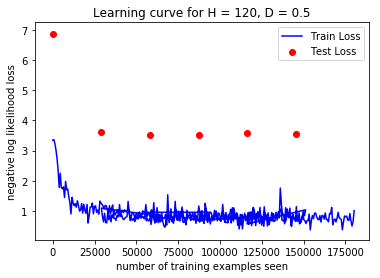


Net with H = 120, D = 0.7

Test set: Avg. loss: 6.8844, Accuracy: 108/9686 (1%)


Test set: Avg. loss: 3.5576, Accuracy: 9584/9686 (98%)


Test set: Avg. loss: 3.5444, Accuracy: 9600/9686 (99%)


Test set: Avg. loss: 3.5127, Accuracy: 9598/9686 (99%)


Test set: Avg. loss: 3.5336, Accuracy: 9598/9686 (99%)


Test set: Avg. loss: 3.4947, Accuracy: 9630/9686 (99%)



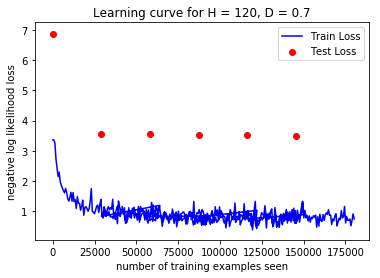


Net with H = 320, D = 0

Test set: Avg. loss: 6.8814, Accuracy: 148/9686 (1%)


Test set: Avg. loss: 3.5290, Accuracy: 9579/9686 (98%)


Test set: Avg. loss: 3.5186, Accuracy: 9600/9686 (99%)


Test set: Avg. loss: 3.4997, Accuracy: 9612/9686 (99%)


Test set: Avg. loss: 3.5110, Accuracy: 9617/9686 (99%)


Test set: Avg. loss: 3.5161, Accuracy: 9616/9686 (99%)



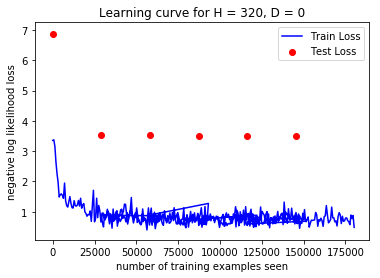


Net with H = 320, D = 0.3

Test set: Avg. loss: 6.8809, Accuracy: 163/9686 (1%)


Test set: Avg. loss: 3.5657, Accuracy: 9593/9686 (99%)


Test set: Avg. loss: 3.5417, Accuracy: 9605/9686 (99%)


Test set: Avg. loss: 3.5425, Accuracy: 9592/9686 (99%)


Test set: Avg. loss: 3.5472, Accuracy: 9619/9686 (99%)


Test set: Avg. loss: 3.4973, Accuracy: 9620/9686 (99%)



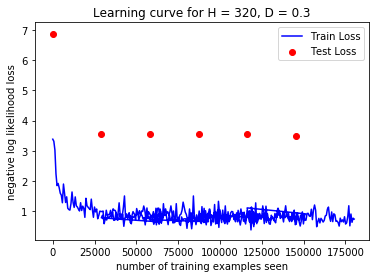


Net with H = 320, D = 0.5

Test set: Avg. loss: 6.8807, Accuracy: 268/9686 (2%)


Test set: Avg. loss: 3.5448, Accuracy: 9604/9686 (99%)


Test set: Avg. loss: 3.5162, Accuracy: 9616/9686 (99%)


Test set: Avg. loss: 3.5408, Accuracy: 9605/9686 (99%)


Test set: Avg. loss: 3.5318, Accuracy: 9588/9686 (98%)


Test set: Avg. loss: 3.5325, Accuracy: 9591/9686 (99%)



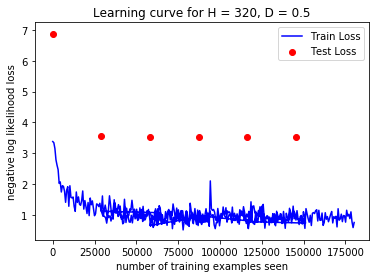


Net with H = 320, D = 0.7

Test set: Avg. loss: 6.8813, Accuracy: 266/9686 (2%)


Test set: Avg. loss: 3.6335, Accuracy: 9499/9686 (98%)


Test set: Avg. loss: 3.6217, Accuracy: 9503/9686 (98%)


Test set: Avg. loss: 3.5858, Accuracy: 9522/9686 (98%)


Test set: Avg. loss: 3.5884, Accuracy: 9517/9686 (98%)


Test set: Avg. loss: 3.5620, Accuracy: 9544/9686 (98%)



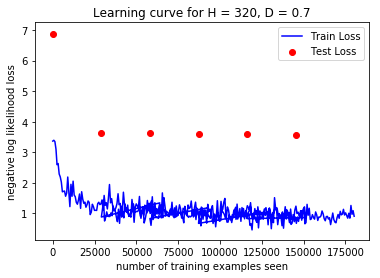

In [31]:
n_epochs = 5

for H in [50, 120, 320]:
    for D in [0, 0.3, 0.5, 0.7]:
        net = Net(H, D)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
        
        train_losses = []
        train_counter = []
        test_losses = []
        test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
        
        print("\nNet with H = {}, D = {}".format(H, D))
        
        test()
        for epoch in range(1, n_epochs + 1):
            train(epoch, False)
            test()
            
        fig = plt.figure()
        plt.plot(train_counter, train_losses, color='blue')
        plt.scatter(test_counter, test_losses, color='red')
        plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
        plt.xlabel('number of training examples seen')
        plt.ylabel('negative log likelihood loss')
        plt.title('Learning curve for H = {}, D = {}'.format(H, D))
        plt.show()   

http://ceur-ws.org/Vol-1885/93.pdf
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/34843.pdf